EDICT Image Editing Pipeline

This pipeline implements the text-guided image editing approach from the paper [EDICT: Exact Diffusion Inversion via Coupled Transformations](https://arxiv.org/abs/2211.12446). You have to pass:

1) (PIL) image you want to edit.
2) base_prompt: the text prompt describing the current image (before editing).
3) target_prompt: the text prompt describing with the edits. 

The script was contributed by [Joqsan](https://github.com/Joqsan) and the notebook by [Parag Ekbote](https://github.com/ParagEkbote).

In [1]:
pip install transformers diffusers pillow torch ipython

Note: you may need to restart the kernel to use updated packages.


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

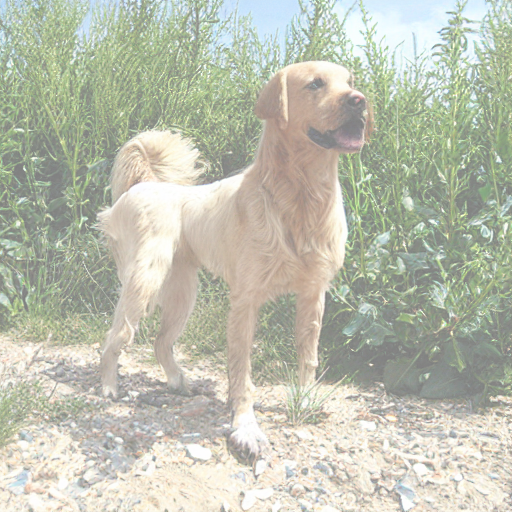

In [9]:
from diffusers import DiffusionPipeline, DDIMScheduler
from transformers import CLIPTextModel
import torch, PIL, requests
from io import BytesIO
from IPython.display import display

def center_crop_and_resize(im):

    width, height = im.size
    d = min(width, height)
    left = (width - d) / 2
    upper = (height - d) / 2
    right = (width + d) / 2
    lower = (height + d) / 2

    return im.crop((left, upper, right, lower)).resize((512, 512))

torch_dtype = torch.float16
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# scheduler and text_encoder param values as in the paper
scheduler = DDIMScheduler(
        num_train_timesteps=1000,
        beta_start=0.00085,
        beta_end=0.012,
        beta_schedule="scaled_linear",
        set_alpha_to_one=False,
        clip_sample=False,
)

text_encoder = CLIPTextModel.from_pretrained(
    pretrained_model_name_or_path="openai/clip-vit-large-patch14",
    torch_dtype=torch_dtype,
)

# initialize pipeline
pipeline = DiffusionPipeline.from_pretrained(
    pretrained_model_name_or_path="CompVis/stable-diffusion-v1-4",
    custom_pipeline="edict_pipeline",
    variant="fp16",
    scheduler=scheduler,
    text_encoder=text_encoder,
    leapfrog_steps=True,
    torch_dtype=torch_dtype,
).to(device)

# download image
image_url = "https://huggingface.co/datasets/Joqsan/images/resolve/main/imagenet_dog_1.jpeg"
response = requests.get(image_url)
image = PIL.Image.open(BytesIO(response.content))

# preprocess it
cropped_image = center_crop_and_resize(image)

# define the prompts
base_prompt = "A dog"
target_prompt = "A golden retriever"

# run the pipeline
result_image = pipeline(
      base_prompt=base_prompt,
      target_prompt=target_prompt,
      image=cropped_image,
)

final_image = result_image[0]

# Save the image
final_image.save("image2.jpg")

# Optionally display the image
final_image.show()